In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import preproccessing as prep
from evaluation import show_scenarios_evaluation
from regime_switching_brownian_motion import RegimeSwitching
from independent_lognormal_model import IndependentLogNormal



In [2]:
def convert_regime_params(params: pd.Series, k):
    """
    params: scipy stats regime params object
    k: number of regimes

    returns annulised params tumple (mean, sigma, transition matrix)
    """
    mu = np.zeros(k)
    sigmas = np.zeros(k)
    transition_matrix = np.zeros((k,k))
    
    for i in range (k):
        mu[i] = params[f'const[{i}]']
        sigmas[i] = np.sqrt(params[f'sigma2[{i}]'])
        
    for i in range(k):
        for j in range(k-1):
            transition_matrix[i,j] = params[f'p[{i}->{j}]']

    transition_matrix[:,-1] = 1 - transition_matrix.sum(axis=1)

            
    return mu, sigmas, transition_matrix

def params_summary(mus,sigmas,transition_matrix,current_regime):
    print('mus: ')
    print(mus * 12)
    print('sigmas: ')
    print(sigmas * np.sqrt(12))
    print('transition matrix: ')
    print(transition_matrix)
    print('current_regime: ')
    print(current_regime)

def estimate_markov_regime_switching_params(data,period):
    n_regimes = 2
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True
    )

    result = model.fit() 

    mus, sigmas, transition_matrix = convert_regime_params(result.params, n_regimes)

    current_regime = np.argmax([result.smoothed_marginal_probabilities[0].iloc[-1],result.smoothed_marginal_probabilities[1].iloc[-1]])

    #return {'mus':mus, 'sigmas': sigmas, 'transition_matrix': transition_matrix, 'current_regime': current_regime}
    return mus,sigmas,transition_matrix,current_regime

In [21]:
def show_RSLN_scenarios_evaluation(mus, sigmas, transition_matrix, initial_values, current_regime, dt, n_scenarios, n_steps, hist):
    
    model = RegimeSwitching(
    models=[IndependentLogNormal(mu=mus[0],sigma=[sigmas[0]]),
            IndependentLogNormal(mu=mus[1],sigma=[sigmas[1]])],
    probs=transition_matrix
    )

    scenarios = model.scenarios(initial_values,current_regime,dt,n_steps, n_scenarios)
    scenarios = pd.DataFrame(data=scenarios, index=range(n_scenarios), columns=range(n_steps+1))

    show_scenarios_evaluation(scenarios,hist)

def convert_to_transition_matrix(p00,p10):
     k =2
     transition_matrix = np.zeros((k,k))
     transition_matrix[0,0] = p00
     transition_matrix[1,0] = p10
     transition_matrix[:,1] = 1 - transition_matrix[:,0]
     return transition_matrix

In [4]:
#'acwi_25.08.23.csv' - curvo file
acwi = pd.read_csv('acwi_25.08.23.csv',index_col='Date', parse_dates=True)
acwi = acwi.squeeze()
acwi.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 428 entries, 1987-12-01 to 2023-07-01
Series name: MSCI ACWI
Non-Null Count  Dtype  
--------------  -----  
428 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


<AxesSubplot:xlabel='Date'>

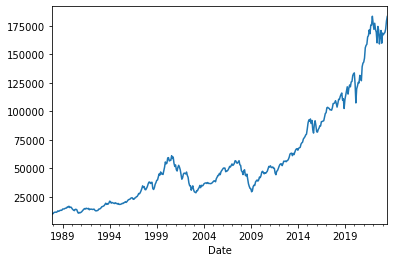

In [5]:
acwi.plot()

<AxesSubplot:xlabel='Date'>

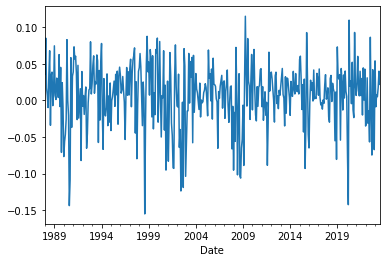

In [6]:

acwi_returns = prep.log_returns(acwi)
display(acwi_returns.plot())


<AxesSubplot:xlabel='MSCI ACWI', ylabel='Count'>

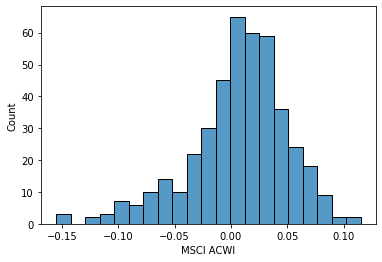

In [7]:
sns.histplot(data=acwi_returns)

In [8]:
periods = [('1988-01-01', '2023-07-01'),
           ('1988-01-01', '2019-12-31'),
           ('1993-01-01', '2023-07-01'),
           ('1994-01-01', '2023-07-01'),
           ('2003-07-01', '2023-07-01'),
           ('1990-01-01', '2019-12-01'),
           ('1990-01-01', '2023-12-01'),
           ('2003-01-01', '2019-12-01'),
           ('2003-01-01', '2014-12-01'),
           ('2003-01-01', '2015-12-31')
           ]

prep.asset_stats(acwi_returns, periods)


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1988-01-01, 2023-07-01)",0.081733,0.149146,-0.752104,1.046907,1.201552,-0.532364
"(1988-01-01, 2019-12-31)",0.080875,0.147638,-0.771985,0.986771,1.193709,-0.532364
"(1993-01-01, 2023-07-01)",0.083378,0.146611,-0.756393,1.111305,1.261200,-0.532364
"(1994-01-01, 2023-07-01)",0.075583,0.146863,-0.744435,1.132014,1.075167,-0.532364
"(2003-07-01, 2023-07-01)",0.086909,0.132992,-0.713923,1.652872,1.482332,-0.481111
"(1990-01-01, 2019-12-01)",0.070984,0.148877,-0.774547,0.948744,0.953616,-0.532364
"(1990-01-01, 2023-12-01)",0.072948,0.150338,-0.752420,1.013315,0.989601,-0.532364
"(2003-01-01, 2019-12-01)",0.085253,0.126505,-0.704987,1.339804,1.513006,-0.481111
"(2003-01-01, 2014-12-01)",0.078403,0.128664,-0.713534,1.498697,1.303195,-0.481111
"(2003-01-01, 2015-12-31)",0.079330,0.133208,-0.642383,1.166177,1.282835,-0.481111


c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


mus: 
[ 0.15978472 -0.10969553]
sigmas: 
[0.08397417 0.19555126]
transition matrix: 
[[0.95462394 0.04537606]
 [0.08425921 0.91574079]]
current_regime: 
1
Sample paths


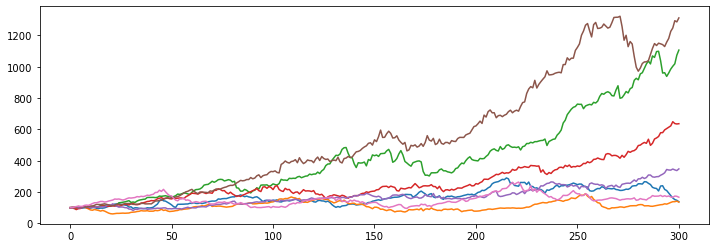

None
Fanchart


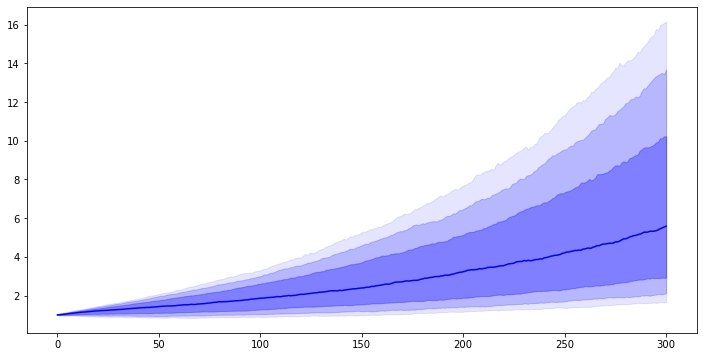

None
Percentaile summary


,12,36,60,120,240,300
10,0.942592,0.879620,0.850924,0.942235,1.332467,1.662524
15,0.984266,0.961362,0.961447,1.102557,1.631147,2.126126
25,1.047519,1.085630,1.135200,1.406678,2.240960,2.931204
50,1.139225,1.326418,1.496147,2.065730,3.948816,5.583698
75,1.215864,1.559430,1.918048,2.997330,6.815648,10.230276
85,1.257411,1.693211,2.149583,3.562690,8.818929,13.693920
90,1.287242,1.764835,2.304476,3.968226,10.405532,16.168812


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.067182,0.137784,-0.615493,1.969211,1.000765,-0.453960
std,0.036373,0.012975,0.279704,0.960067,0.983416,0.138393
min,-0.066973,0.099104,-1.718449,-0.060167,-2.067254,-0.935754
25%,0.043016,0.128756,-0.794057,1.304374,0.305862,-0.542538
50%,0.068794,0.137720,-0.618581,1.809060,0.959841,-0.440777
75%,0.093014,0.146835,-0.434958,2.446789,1.680439,-0.350476
max,0.173349,0.179294,0.314344,7.226227,4.532690,-0.119084


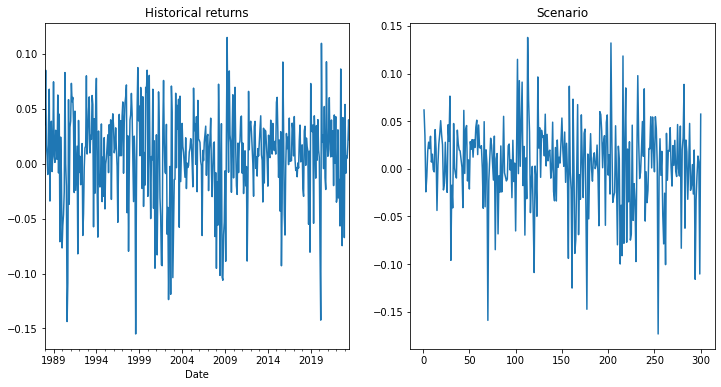

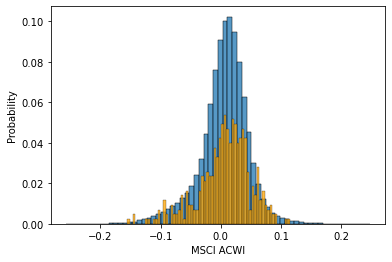

In [9]:
mus,sigmas,transition_matrix,current_regime = estimate_markov_regime_switching_params(acwi_returns,('2003-01-01', '2015-12-31'))
params_summary(mus,sigmas,transition_matrix,current_regime)

show_RSLN_scenarios_evaluation(mus,sigmas,transition_matrix,
                               initial_values=100,
                               current_regime=0,
                               dt=1,
                               n_scenarios=2000,
                               n_steps= 300,
                               hist=acwi_returns)

In [10]:
periods = [('1988-01-01', '2023-07-01'),
           ('1988-01-01', '2019-12-31'),
           ('1993-01-01', '2023-07-01'),
           ('1994-01-01', '2023-07-01'),
           ('2003-07-01', '2023-07-01'),
           ('1990-01-01', '2019-12-01'),
           ('1990-01-01', '2023-12-01'),
           ('2003-01-01', '2019-12-01'),
           ('2003-01-01', '2014-12-01'),
           ('2003-01-01', '2015-12-31')
           ]

data = acwi_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1988-01-01, 2023-07-01)",93.49,9.16,1.60,-0.58,0.07,0.32
"(1988-01-01, 2019-12-31)",94.95,6.50,1.51,-0.35,0.07,0.30
"(1993-01-01, 2023-07-01)",94.23,7.22,1.43,-0.19,0.06,0.31
"(1994-01-01, 2023-07-01)",94.33,6.71,1.36,-0.24,0.06,0.31
"(2003-07-01, 2023-07-01)",92.99,14.73,1.39,-0.67,0.05,0.32
"(1990-01-01, 2019-12-01)",95.13,4.81,1.35,-0.16,0.06,0.30
"(1990-01-01, 2023-12-01)",93.66,6.51,1.45,-0.26,0.06,0.31
"(2003-01-01, 2019-12-01)",94.63,11.42,1.31,-0.62,0.05,0.29
"(2003-01-01, 2014-12-01)",96.17,9.18,1.25,-0.92,0.05,0.32
"(2003-01-01, 2015-12-31)",95.46,8.43,1.33,-0.91,0.06,0.32


Sample paths


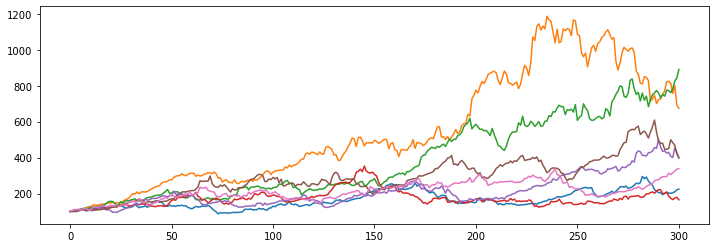

None
Fanchart


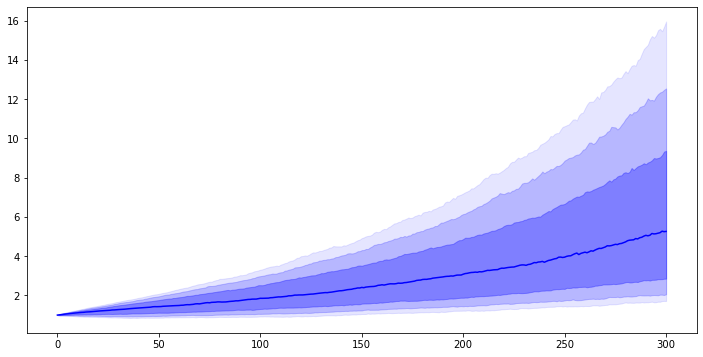

None
Percentaile summary


,12,36,60,120,240,300
10,0.924943,0.852366,0.890163,0.930685,1.392530,1.715475
15,0.969187,0.939834,0.982312,1.105151,1.678579,2.061670
25,1.034930,1.077933,1.149415,1.388840,2.245080,2.855428
50,1.135578,1.329392,1.488589,2.024605,3.690584,5.260143
75,1.223513,1.571104,1.907706,2.909669,6.169249,9.361994
85,1.272118,1.697017,2.141812,3.471360,8.224055,12.541960
90,1.305702,1.792302,2.323832,3.999305,9.776296,15.950905


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.065523,0.142920,-0.571850,1.927288,0.910453,-0.440320
std,0.034751,0.012272,0.285229,0.906455,0.905538,0.129826
min,-0.076264,0.097759,-1.667627,0.101886,-2.405016,-0.937676
25%,0.041969,0.134863,-0.751053,1.313754,0.269745,-0.523008
50%,0.066406,0.143190,-0.562081,1.766018,0.890690,-0.425874
75%,0.089466,0.151281,-0.389089,2.402189,1.497889,-0.345532
max,0.189295,0.179610,0.522960,7.632738,4.165643,-0.120760


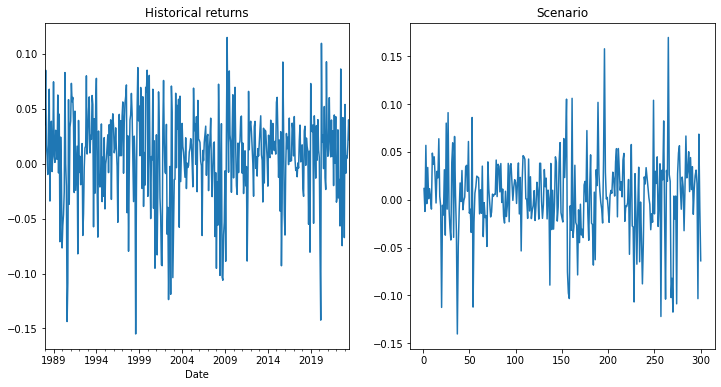

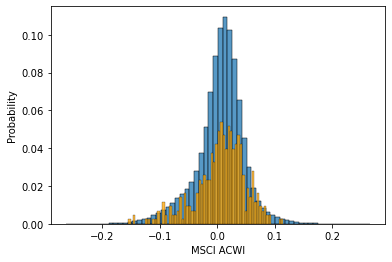

In [13]:
transition_matrix = [[0.93487726, 0.06512274],
                     [0.09158072, 0.90841928]]
mus = np.divide([ 0.16663396, -0.08022406],12)
sigmas = np.divide([0.07695315, 0.19668646], np.sqrt(12) )

show_RSLN_scenarios_evaluation(mus,sigmas,transition_matrix,
                               initial_values=100,
                               current_regime=0,
                               dt=1,
                               n_scenarios=2000,
                               n_steps= 300,
                               hist=acwi_returns)


In [14]:
eurpln = prep.loadStooqData('eurpln','1998-12-01','d')
eurpln = eurpln.resample('MS').last()
acwi_pln = (acwi * eurpln).dropna()
acwi_pln_returns = prep.log_returns(acwi_pln)


In [20]:
periods = [('1999-01-01', '2023-07-01'),                      
           ('2003-07-01', '2023-07-01'),
           ('2003-01-01', '2019-12-01'),           
           ('2013-07-01', '2023-07-01'),
           ('2008-07-01', '2023-07-01'),           
           ('2000-03-01','2021-12-31'),
           ('2002-09-01','2022-09-30'),
           ('2002-09-01','2020-02-28'),
           ]
prep.asset_stats(acwi_pln_returns, periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1999-01-01, 2023-07-01)",0.067608,0.132636,-0.483741,0.587445,0.982235,-0.499747
"(2003-07-01, 2023-07-01)",0.086044,0.120917,-0.327629,0.750427,1.605586,-0.409670
"(2003-01-01, 2019-12-01)",0.088652,0.116869,-0.472766,0.707478,1.738506,-0.409670
"(2013-07-01, 2023-07-01)",0.110610,0.118750,-0.111603,0.983353,2.351502,-0.148220
"(2008-07-01, 2023-07-01)",0.112648,0.117815,-0.233588,0.784225,2.430096,-0.148220
"(2000-03-01, 2021-12-31)",0.061659,0.132059,-0.595957,0.728352,0.830467,-0.499747
"(2002-09-01, 2022-09-30)",0.084880,0.126436,-0.456375,0.859378,1.503614,-0.409670
"(2002-09-01, 2020-02-28)",0.076480,0.123196,-0.635239,0.885435,1.306943,-0.409670


In [19]:
data = acwi_pln_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1999-01-01, 2023-07-01)",95.75,11.08,1.31,-1.33,0.08,0.27
"(1999-01-01, 2019-12-01)",97.40,8.84,1.26,-1.86,0.08,0.27
"(1999-09-01, 2023-07-01)",95.36,9.58,1.25,-1.02,0.07,0.26
"(2001-01-01, 2023-07-01)",95.06,10.47,1.24,-1.06,0.07,0.26
"(2003-01-01, 2023-07-01)",95.66,14.28,1.21,-0.71,0.07,0.26
"(2003-01-01, 2019-12-01)",97.47,13.01,1.14,-1.29,0.07,0.27
"(2013-07-01, 2023-07-01)",91.17,13.63,1.28,0.41,0.05,0.21
"(2008-07-01, 2023-07-01)",93.81,11.36,1.24,0.36,0.05,0.23
"(2002-09-01, 2022-09-30)",95.36,12.51,1.24,-0.95,0.07,0.29
"(1990-09-01, 2022-09-30)",95.91,10.25,1.34,-1.44,0.08,0.27


Sample paths


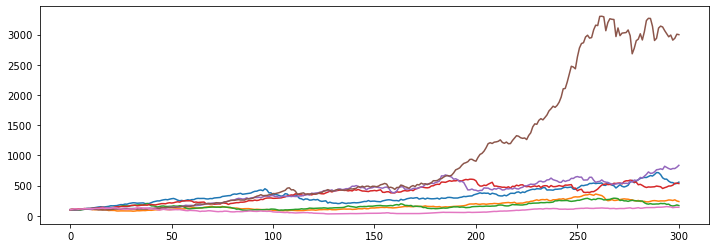

None
Fanchart


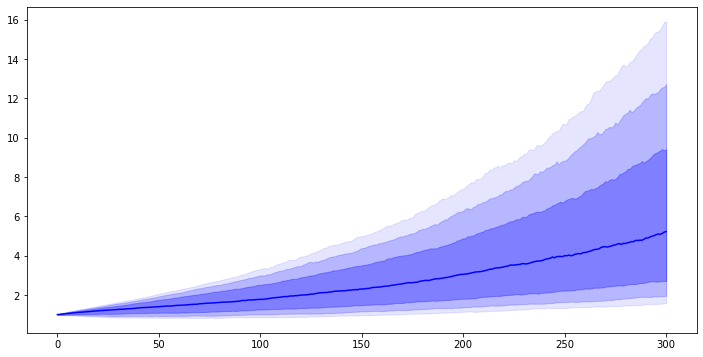

None
Percentaile summary


,12,36,60,120,240,300
10,0.932900,0.852592,0.841071,0.883570,1.322295,1.596481
15,0.973370,0.934696,0.934875,1.057345,1.555160,1.958208
25,1.028595,1.071145,1.105244,1.335234,2.115316,2.721041
50,1.123513,1.303025,1.473986,1.991202,3.791583,5.226927
75,1.207826,1.536644,1.888191,2.899194,6.298221,9.409523
85,1.252697,1.662939,2.108901,3.473832,8.349711,12.733262
90,1.286118,1.742386,2.265325,3.958145,9.753539,15.913141


Scenarios summary stats


,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,0.064626,0.129854,-0.652469,1.649017,0.988392,-0.452865
std,0.036290,0.011014,0.264745,0.884022,1.034288,0.145717
min,-0.079619,0.095252,-1.756794,0.067865,-2.462861,-0.923405
25%,0.040041,0.122165,-0.818056,1.045636,0.259244,-0.545475
50%,0.066153,0.129851,-0.651884,1.473139,0.980017,-0.438586
75%,0.089669,0.137364,-0.482023,2.062391,1.682110,-0.343961
max,0.156957,0.162366,0.220897,9.646920,4.277069,-0.106594


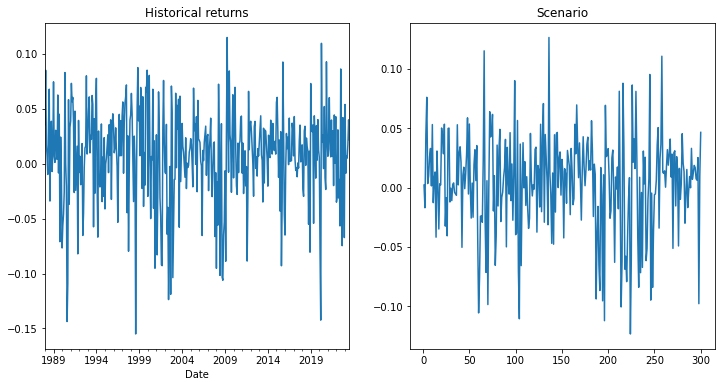

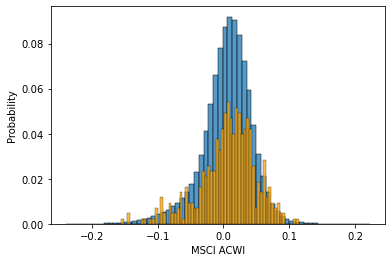

In [27]:
transition_matrix = convert_to_transition_matrix(96.05/100,10.4/100)

mus = [ 0.013, -0.0153]
sigmas = np.sqrt([0.0007, 0.0028])

show_RSLN_scenarios_evaluation(mus,sigmas,transition_matrix,
                               initial_values=100,
                               current_regime=0,
                               dt=1,
                               n_scenarios=2000,
                               n_steps= 300,
                               hist=acwi_returns)

5,7.2,9.6

### porownanie
regime switching 1990-2013:  
params .. 
curretirns percentile  
|1 | 2 | 3 |
| .. | ... | ... |  
assets stats 